In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sklearn
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import optimizers
from sklearn.model_selection import train_test_split
import seaborn as sns

In [5]:
# Mounting Drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_data():
  # Reads the dataframes and concats all features
  # Returns: Data df
  df=pd.read_csv('drive/My Drive/FYP/Energies/energy_i5_3gen.csv',delimiter=';',dtype={'Time':np.float64,'Energy(J)':np.float64})
  df2=pd.read_csv('drive/My Drive/FYP/Energies/energy_i5_4gen.csv',delimiter=';',dtype={'Time':np.float64,'Energy(J)':np.float64})
  df3=pd.read_csv('drive/My Drive/FYP/Energies/energy_i7_6gen.csv',delimiter=';',dtype={'Time':np.float64,'Energy(J)':np.float64})
  df4=pd.read_csv('drive/My Drive/FYP/Energies/energy_i7_6gen_1.csv',delimiter=';',dtype={'Time':np.float64,'Energy(J)':np.float64})
  feats=pd.read_csv('drive/My Drive/FYP/Energies/features.csv',delimiter=';')
  df["tdp"]=55
  df2["tdp"]=37
  df3["tdp"]=65
  df4["tdp"]=65
  ndf=pd.concat([df3,df4])



  i5_3gen=pd.merge(df,feats,how='left',left_on=['Name','Iter'], right_on = ['Name','Iter'])
  i5_4gen=pd.merge(df2,feats,how='left',left_on=['Name','Iter'], right_on = ['Name','Iter'])
  i7_6gen=pd.merge(ndf,feats,how='left',left_on=['Name','Iter'], right_on = ['Name','Iter'])
  i5_3gen=i5_3gen.dropna()
  i5_4gen=i5_4gen.dropna()
  i7_6gen=i7_6gen.dropna()
  data=pd.concat([i5_3gen,i5_4gen,i7_6gen])

  size=pd.read_csv('drive/My Drive/FYP/Energies/data_size.csv')
  size["Name"]=size["Name"].str.replace('_data','')
  size["Iter"]=size["Iter"].astype(str)

  data.Name[data.Name=='automotive_susan_c']='automotive_susan'
  data.Name[data.Name=='consumer_tiff2rgba']='consumer_tiff'
  data.Name[data.Name=='consumer_tiffdither']='consumer_tiff'
  data.Name[data.Name=='consumer_tiffmedian']='consumer_tiff'
  data.Name[data.Name=='security_blowfish_e']='security_blowfish'
  data.Name[data.Name=='telecom_adpcm_c']='telecom_adpcm'
  data.Name[data.Name=='telecom_adpcm_d']='telecom_adpcm'
#   data=data[data.Name != 'network_dijkstra']

  ndf=pd.merge(data,size,how='left',left_on=['Name','Iter'], right_on = ['Name','Iter'])
  data=ndf.dropna()
  
  return data



def normalize(data):
  # Removes outlier Energy Values keeping only -3 to +3 std
  # Normalizes the size
  data = data.rename(columns={'Energy(J)': 'Energy'})
  data=data.drop(data.index[data.Energy==0])
  data=data[np.abs(data.Energy-data.Energy.mean()) <= (4*data.Energy.std())] #Only keep -3 to +3 std values of Energy

  # Normalization
  e_max=data["Energy"].max()
  e_min=data["Energy"].min()
  data["Energy"]=(data["Energy"]-e_min)/(e_max-e_min)
  
  print "MAX: ",e_max
  print "MIN: ",e_min
  # labels=(data["Energy"]-e_min)/(e_max-e_min)

  # Size Normalization
  mean=data["Size(B)"].mean()
  sdev=data["Size(B)"].std()
  
  print "Mean: ",mean
  print "Std: ",sdev
  data["Size(B)"]=(data["Size(B)"]-data["Size(B)"].mean())/data["Size(B)"].std()
  
  return data
  

def init():
  df=read_data()
  return normalize(df)

In [0]:
class Model:
  
  def __init__(self):
    self.df=init()
    
    
  def train(self):
    self.X_train,self.X_test,self.Y_train,self.Y_test=train_test_split(self.df.iloc[:,5:13],self.df.iloc[:,4:5],test_size=0.3)
    self.build_layer1(self.X_train,self.X_test,self.Y_train,self.Y_test)
#     self.build_layer2()
  
  
  def randomforest(self,depth=8,estimators=15):
    from sklearn.ensemble import RandomForestRegressor
#     params={'n_estimators': 5, 'max_features': 'auto', 'bootstrap': False, 'max_depth': 25}
#     regr = RandomForestRegressor(max_depth=depth, n_estimators=estimators)
    regr = RandomForestRegressor(n_estimators=estimators,max_depth=depth,bootstrap=False,max_features='auto')
    return regr
    
  def extratrees(self,depth=8,estimators=15):
    from sklearn.ensemble import ExtraTreesRegressor
#     {'n_estimators': 5, 'max_features': 'auto', 'bootstrap': False, 'max_depth': 25}
    regr2 = ExtraTreesRegressor(max_depth=depth,n_estimators=estimators,bootstrap=False,max_features='auto')
    return regr2
    
  def gradboost(self,depth=5,estimators=15):
    from sklearn.ensemble import GradientBoostingRegressor
    regr = GradientBoostingRegressor(n_estimators=estimators, learning_rate=0.2,max_depth=depth, random_state=0, loss='ls')
    return regr
  
  
  def neural_network(self,learning=0.001):
    model = Sequential()
    model.add(Dense(10, input_dim=8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(5, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.summary()
    
    o = optimizers.Adam(lr=learning, decay=1e-6)
    model.compile(loss='mse', optimizer=o, metrics=['mse','mae'])
    return model
  
  
      
    
  def build_layer1(self,X_train,X_test,Y_train,Y_test):
    rf=self.randomforest()
    et=self.extratrees()
    gb=self.gradboost()
    
    
    #Random Forest Regressor
    rf.fit(X_train,Y_train)
    rf_pred=rf.predict(X_test)
    rf_mae=sklearn.metrics.mean_absolute_error(Y_test.values,rf_pred)
    rf_r2=sklearn.metrics.r2_score(Y_test.values,rf_pred)
    
    print "-----------Model: Random Forest--------------"
    print "           Mean Absolute Error: ",rf_mae
    print "           R2 Score:           ", rf_r2
    
    
    
    
    #Extra Trees
    et.fit(X_train,Y_train)
    et_pred=et.predict(X_test)
    et_mae=sklearn.metrics.mean_absolute_error(Y_test.values,et_pred)
    et_r2=sklearn.metrics.r2_score(Y_test.values,et_pred)
    
    print "-----------Model: Extra Trees----------------"
    print "           Mean Absolute Error: ",et_mae
    print "           R2 Score:           ", et_r2
    
    
    #Gradient Boosting 
    gb.fit(X_train,Y_train)
    gb_pred=gb.predict(X_test)
    gb_mae=sklearn.metrics.mean_absolute_error(Y_test.values,gb_pred)
    gb_r2=sklearn.metrics.r2_score(Y_test.values,gb_pred)
    
    print "-----------Model: Gradient Boosting--------------"
    print "           Mean Absolute Error: ",gb_mae
    print "           R2 Score:           ", gb_r2
    

    
    
    
    #Combined Model
    c_pred=(gb_pred+et_pred+rf_pred)/3.0
    c_mae=sklearn.metrics.mean_absolute_error(Y_test.values,c_pred)
    c_r2=sklearn.metrics.r2_score(Y_test.values,c_pred)
  
    print "-----------Model: Combined-------------------------"
    print "           Mean Absolute Error: ",c_mae
    print "           R2 Score:           ", c_r2
    
    self.rf=rf
    self.et=et
    self.gb=gb
    
    
    
    p1=rf.predict(self.df.iloc[:,5:13])
    p2=et.predict(self.df.iloc[:,5:13])
    p3=gb.predict(self.df.iloc[:,5:13])
    self.ndf=self.df.copy()
    
    
    
    self.ndf["final"]=(p1+p2+p3)/3.0
    # For Graphs
    self.ndf["ET"]=p2
    self.ndf["RF"]=p1
    self.ndf["GB"]=p3
#     self.ndf["NN"]=p4
    
    
    
    
    
    
  def build_layer2(self):
    X_train,X_test,Y_train,Y_test=train_test_split(self.ndf.iloc[:,5:14],self.ndf.iloc[:,4:5],test_size=0.2)
    nn=self.neural_network()
    history = nn.fit(X_train, Y_train, epochs=10, batch_size=50,  verbose=1, validation_split=0.2)
    
    
    #Combined Model
    nn_pred=nn.predict(X_test)
    nn_mae=sklearn.metrics.mean_absolute_error(Y_test.values,nn_pred)
    nn_r2=sklearn.metrics.r2_score(Y_test.values,nn_pred)
  
    print "-----------Model: Layer 2-------------------------"
    print "           Mean Absolute Error: ",nn_mae
    print "           R2 Score:           ", nn_r2
    
    p1=nn.predict(self.ndf.iloc[:,5:14])
    self.ndf["layer2"]=p1
    self.network=nn
  
  
  
  def predict(self,val):    
    pred=(self.rf.predict(val)+self.et.predict(val))/2.0
    nval=np.append(val,pred)
    nval=nval.reshape(1,-1)
    return self.network.predict(nval)
  
  
  
  def predict2(self,val):
    
    et=(self.et.predict(val))
    gb=(self.gb.predict(val))
    rf=(self.rf.predict(val))
    comb=(rf+et+gb)/3.0
    
    print "ET: ",et
    print "GB: ",gb
    print "RF: ",rf 
      
    return comb
    
    
  def Random_Forest_tuning(self):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import RandomizedSearchCV
   
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
    
    
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter =5, cv = 3, verbose=5, random_state=42,n_jobs = -1)
    
    
    self.X_train,self.X_test,self.Y_train,self.Y_test=train_test_split(self.df.iloc[:,5:13],self.df.iloc[:,4:5],test_size=0.2)
    # Fit the random search model
    rf_random.fit(self.X_train, self.Y_train)
    
    print rf_random.best_params_
    
    
  
  
  def Extra_trees_tuning(self):
    from sklearn.ensemble import ExtraTreesRegressor
    from sklearn.model_selection import RandomizedSearchCV
   
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
    
    
    # First create the base model to tune
    rf = ExtraTreesRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter =5, cv = 3, verbose=5, random_state=42,n_jobs = -1)
    
    
    self.X_train,self.X_test,self.Y_train,self.Y_test=train_test_split(self.df.iloc[:,5:13],self.df.iloc[:,4:5],test_size=0.2)
    # Fit the random search model
    rf_random.fit(self.X_train, self.Y_train)
    
    print rf_random.best_params_
   
    

In [120]:
import warnings
warnings.filterwarnings('ignore')
model=Model()
model.train()
# model.Extra_trees_tuning()

MAX:  99.29
MIN:  0.01
Mean:  1404594.7477361772
Std:  2777144.033689179
-----------Model: Random Forest--------------
           Mean Absolute Error:  0.0018081918743635182
           R2 Score:            0.9087058235799167
-----------Model: Extra Trees----------------
           Mean Absolute Error:  0.0020463521959779357
           R2 Score:            0.859392504079878
-----------Model: Gradient Boosting--------------
           Mean Absolute Error:  0.001980670819901004
           R2 Score:            0.8925691310006818
-----------Model: Combined-------------------------
           Mean Absolute Error:  0.001818962919577304
           R2 Score:            0.9025913535634408


In [89]:
(28-1404594.7477361772)/2777144.033689179

-0.5057594171197308

In [121]:
arr=[15,8,11,3,2,3,3,-0.5057594171197308]
arr=np.array(arr)
arr=arr.reshape(1, -1)
# print arr[0]
model.predict2(arr)
# arr.reshape(1,1)
# arr2=np.append(arr,100)

ET:  [0.00234245]
GB:  [0.00939816]
RF:  [0.01148786]


array([0.00774282])

In [124]:
(0.00774282*(99.29-0.01))+0.01

0.7787071696

In [0]:
pred=model.df
X_train,X_test,Y_train,Y_test=train_test_split(pred.iloc[:,5:13],pred.iloc[:,4:5],test_size=0.2)
pred=pred.loc[Y_test.index]

In [0]:
prediction=model.et.predict(X_test)
pred['prediction']=prediction

<function matplotlib.pyplot.show>

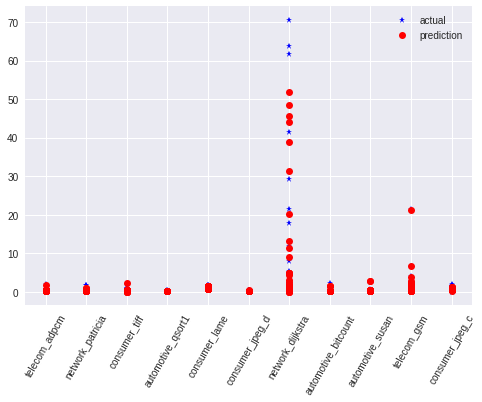

In [0]:
# Plot the actual values
plt.plot(pred.iloc[0:1000]['Name'], pred.iloc[0:1000]['Energy'], 'b*', label = 'actual')
# Plot the predicted values
plt.plot(pred.iloc[0:1000]['Name'], pred.iloc[0:1000]['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.show

<function matplotlib.pyplot.show>

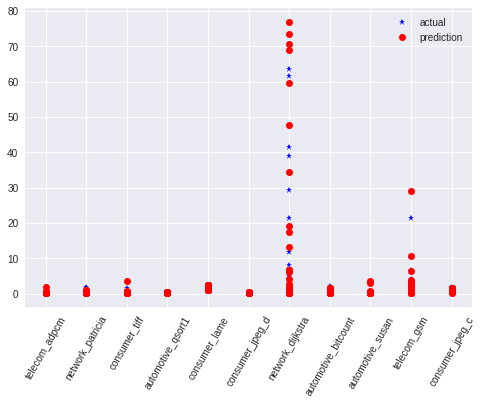

In [0]:
# Plot the actual values
plt.plot(pred.iloc[0:1000]['Name'], pred.iloc[0:1000]['Energy'], 'b*', label = 'actual')
# Plot the predicted values
plt.plot(pred.iloc[0:1000]['Name'], pred.iloc[0:1000]['layer1'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()
plt.show

In [0]:
model.ndf.Name.unique()

array(['automotive_bitcount', 'automotive_qsort1', 'automotive_susan',
       'consumer_jpeg_c', 'consumer_jpeg_d', 'consumer_lame',
       'consumer_tiff', 'network_patricia', 'telecom_adpcm',
       'telecom_gsm'], dtype=object)

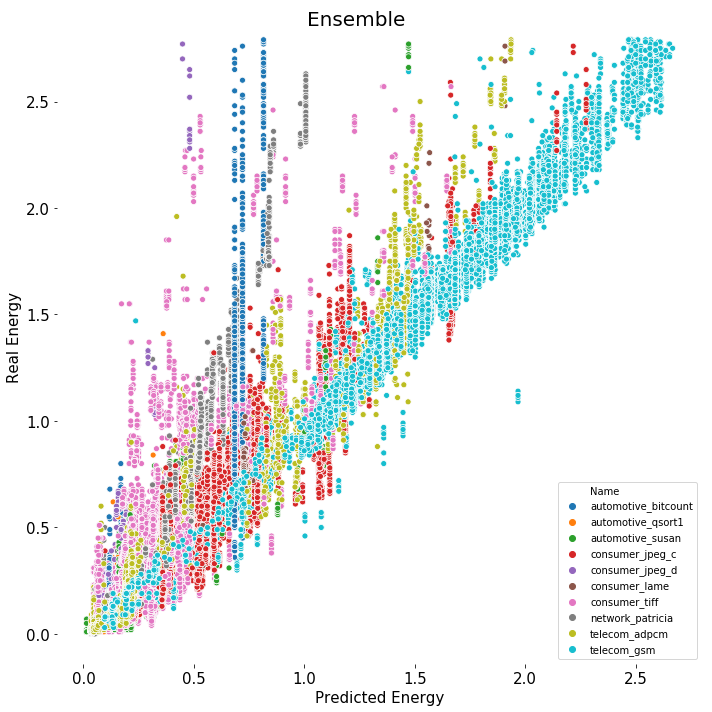

In [0]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Ensemble",fontsize=20)
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(ax=ax,x='final',y='Energy',hue='Name',data=model.ndf)
plt.legend(loc='best')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_xlabel('Predicted Energy',fontsize=15)
ax.set_ylabel('Real Energy',fontsize=15)
plt.tight_layout()
# plt.savefig('ensemble.png')

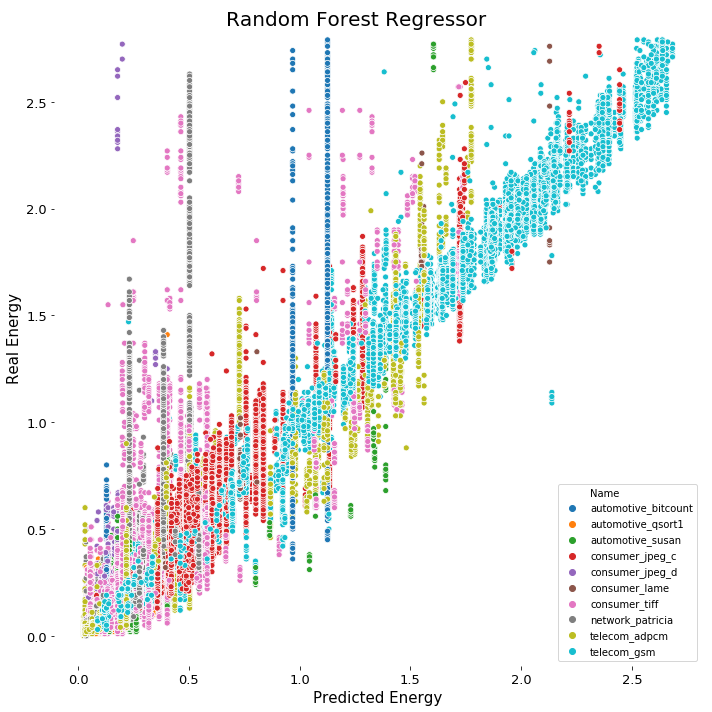

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Random Forest Regressor",fontsize=20)
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(ax=ax,x='RF',y='Energy',hue='Name',data=model.ndf)
plt.legend(loc='best')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_xlabel('Predicted Energy',fontsize=15)
ax.set_ylabel('Real Energy',fontsize=15)
plt.tight_layout()
# plt.savefig('random_forest.png')

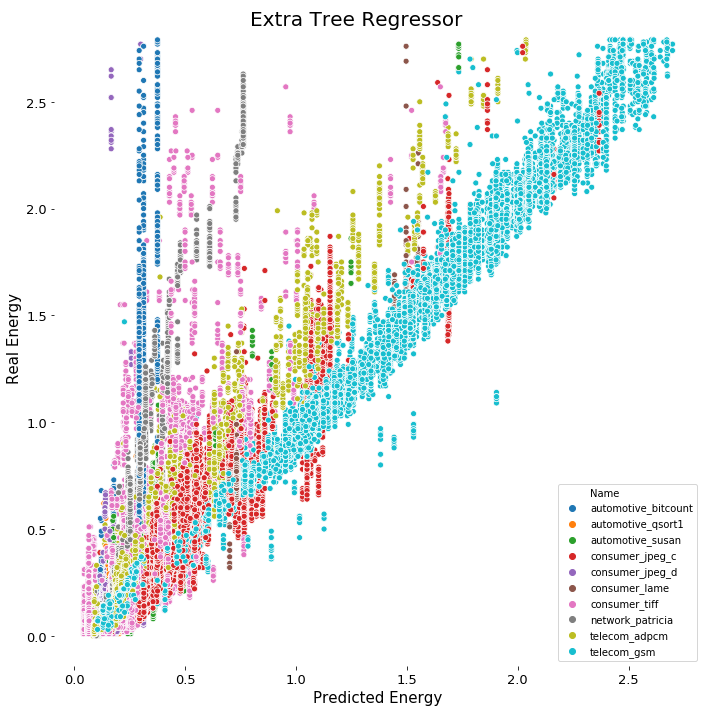

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Extra Tree Regressor",fontsize=20)
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(ax=ax,x='ET',y='Energy',hue='Name',data=model.ndf)
plt.legend(loc='best')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_xlabel('Predicted Energy',fontsize=15)
ax.set_ylabel('Real Energy',fontsize=15)
plt.tight_layout()
# plt.savefig('extra_trees.png')

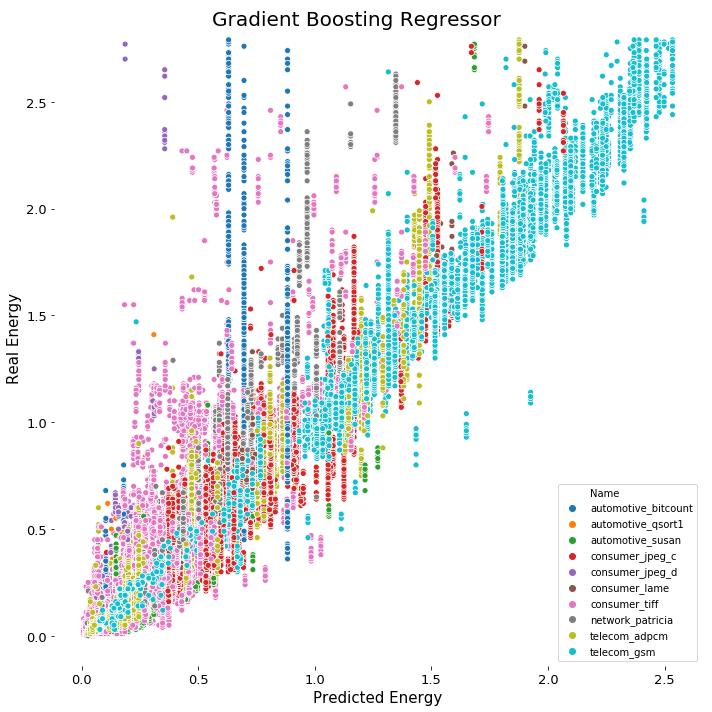

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle("Gradient Boosting Regressor",fontsize=20)
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(ax=ax,x='GB',y='Energy',hue='Name',data=model.ndf)
plt.legend(loc='best')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
ax.set_xlabel('Predicted Energy',fontsize=15)
ax.set_ylabel('Real Energy',fontsize=15)
plt.tight_layout()
# plt.savefig('grad_boost.png')

In [0]:
from google.colab import files

# with open('/content/ensemble.png', 'w') as f:
#   f.write('some content')

files.download('/content/ensemble.png')

In [0]:
# t1=model.ndf["Energy"]
# t2=model.ndf["final"]
# t3=model.ndf["ET"]
# t4=model.ndf["RF"]
# t5=model.ndf["GB"]

new=model.ndf.loc[model.X_test.index][['Name','Energy', 'final', 'ET','RF','GB']].copy()

# new = model.ndf[['Name','Energy', 'final', 'ET','RF','GB']].copy()
new=new.rename(columns={'final': 'Ensemble','ET':'Extra Trees','RF':'Random Forest','GB':'Gradient Boosting'})

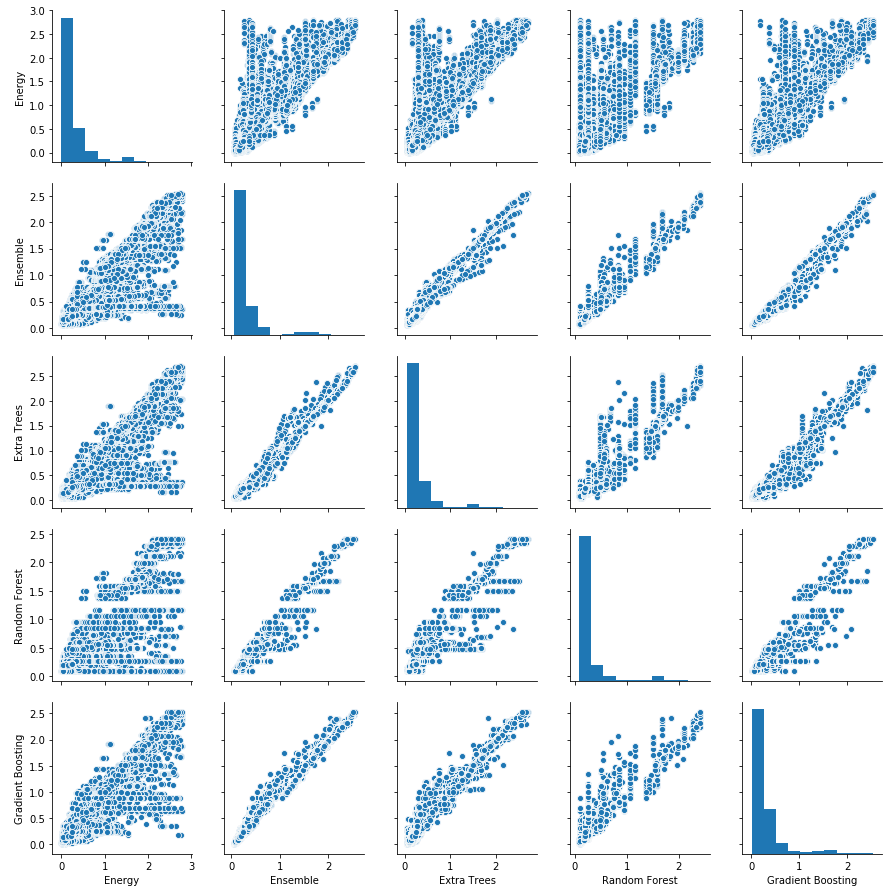

In [0]:
sns.pairplot(new)
# plt.savefig('pairplot.png')

In [0]:
new

,Name,Energy,Ensemble,Extra Trees,Random Forest,Gradient Boosting
0,automotive_bitcount,0.517986,0.169487,0.071418,0.386359,0.050685
2,automotive_bitcount,0.097122,0.054223,0.071418,0.040567,0.050685
3,automotive_bitcount,0.032374,0.051716,0.068903,0.040567,0.045678
4,automotive_bitcount,0.046763,0.054223,0.071418,0.040567,0.050685
5,automotive_bitcount,0.021583,0.054223,0.071418,0.040567,0.050685
6,automotive_bitcount,0.064748,0.054223,0.071418,0.040567,0.050685
7,automotive_bitcount,0.079137,0.054223,0.071418,0.040567,0.050685
8,automotive_bitcount,0.046763,0.054223,0.071418,0.040567,0.050685
9,automotive_bitcount,0.017986,0.054223,0.071418,0.040567,0.050685
10,automotive_bitcount,0.086331,0.054223,0.071418,0.040567,0.050685


<function matplotlib.pyplot.show>

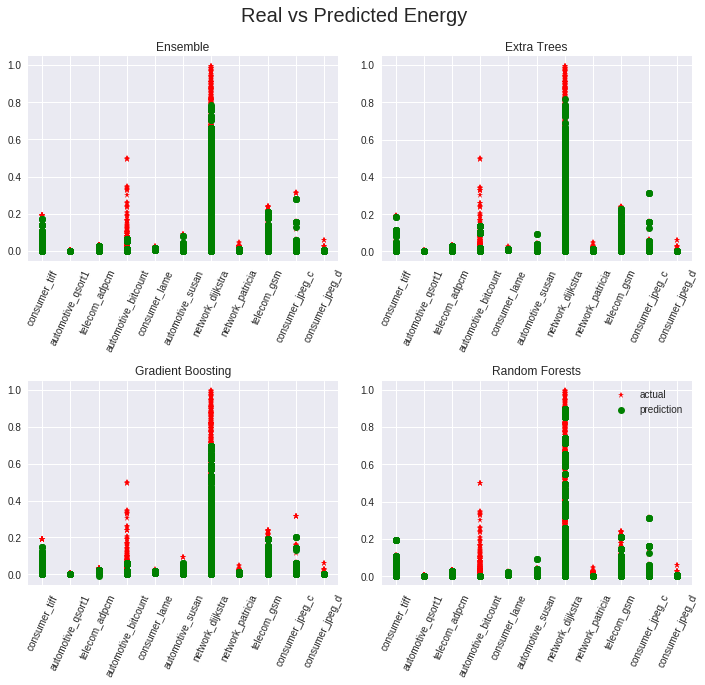

In [126]:
fig, ax = plt.subplots(figsize=(10,10),nrows=2,ncols=2)
fig.suptitle("Real vs Predicted Energy",fontsize=20)

# Plot the actual values
ax[0,0].plot(new['Name'], new['Energy'], 'r*', label = 'actual')
# Plot the predicted values
ax[0,0].plot(new['Name'], new['Ensemble'], 'go', label = 'prediction')
for tick in ax[0,0].get_xticklabels():
        tick.set_rotation(65)
ax[0,0].set_title('Ensemble')
    
    

    
# Plot the actual values
ax[0,1].plot(new['Name'], new['Energy'], 'r*', label = 'actual')
# Plot the predicted values
ax[0,1].plot(new['Name'], new['Extra Trees'], 'go', label = 'prediction')
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(65)
ax[0,1].set_title('Extra Trees')
    
    
# Plot the actual values
ax[1,0].plot(new['Name'], new['Energy'], 'r*', label = 'actual')
# Plot the predicted values
ax[1,0].plot(new['Name'], new['Gradient Boosting'], 'go', label = 'prediction')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(65)
ax[1,0].set_title('Gradient Boosting')

    
# Plot the actual values
ax[1,1].plot(new['Name'], new['Energy'], 'r*', label = 'actual')
# Plot the predicted values
ax[1,1].plot(new['Name'], new['Random Forest'], 'go', label = 'prediction')
for tick in ax[1,1].get_xticklabels():
        tick.set_rotation(65)
ax[1,1].set_title('Random Forests')
    
    

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.legend()
plt.show



In [127]:
from sklearn.externals import joblib
filename = 'finalized_model.sav'
joblib.dump(model.rf,'random_forest_best.sav' )
joblib.dump(model.et,'extra_trees_best.sav' )
joblib.dump(model.gb,'gradient_boosting_best.sav' )

['gradient_boosting_best.sav']

In [0]:
loaded_rf = joblib.load('random_forest.sav')
loaded_et = joblib.load('extra_trees.sav')
loaded_gb = joblib.load('gradient_boosting.sav')

In [23]:
print loaded_rf.predict(arr)
print loaded_et.predict(arr)
print loaded_gb.predict(arr)

[0.01026244]
[0.00765269]
[0.00984718]


In [48]:
(0.00984718*(99.29-0.01))+0.01

0.9876280304